In [1]:
# The Kaggle Python 3 environment comes with many helpful tools installed. 
# See the kaggle/python Docker image: https://github.com/kaggle/docker-python
# If using another environment you may need to install the packages yourself
# e.g. pip install pytorch_lightning or !pip install pytorch_lightning

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, sys # filesystem operations
import matplotlib.pyplot as plt
import cv2
import random
import torch
from torch import nn
import torchvision.transforms as transforms
import pytorch_lightning as pl
from PIL import Image
from argparse import Namespace

# When using Kaggle datasets upload of data is handled behind the scene
# Data files are available in the read-only "../input/" directory
# If you are using something else, you need to upload the data manually
# Here we take a look at the content of the input directory
input_dir = './data'
print(f"input dir contains: {os.listdir(input_dir)}")
dataset_dir = os.path.join(input_dir,'faces-age-detection-dataset')
print(f"dataset dir contains: {os.listdir(dataset_dir)}")
train_dir = os.path.join(dataset_dir,'Train')
print(f"train dir contains: {len(os.listdir(train_dir))} files such as {os.listdir(train_dir)[0]}")

input dir contains: ['faces-age-detection-dataset', 'Train']
dataset dir contains: ['Train', 'train.csv']
train dir contains: 19906 files such as 0.jpg


In [2]:
import torch
import pytorch_lightning as pl

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
if torch.cuda.is_available():
    print("using {}".format(torch.cuda.get_device_name(0)))
else:
    print("using CPU")

using CPU


          ID   Class
0    377.jpg  MIDDLE
1  17814.jpg   YOUNG
2  21283.jpg  MIDDLE
3  16496.jpg   YOUNG
4   4487.jpg  MIDDLE

values ['MIDDLE' 'OLD' 'YOUNG']
counts [10804  2396  6706]
Image ./data\faces-age-detection-dataset\Train\5478.jpg with shape (53, 40, 3) and label YOUNG


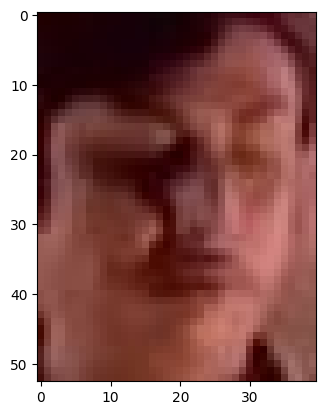

Image ./data\faces-age-detection-dataset\Train\16939.jpg with shape (41, 35, 3) and label MIDDLE


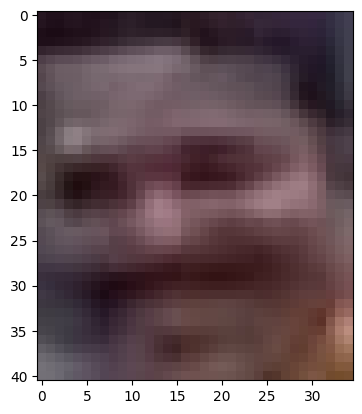

In [3]:
# Lets see what is in 'train.csv'
train_df = pd.read_csv(os.path.join(dataset_dir,'train.csv'))
print(f'{train_df.head()}\n')

# Get an overview of the labels
labels = train_df['Class'].values
values, counts = np.unique(labels, return_counts=True) # count instances for each unique label
print(f'values {values}')
print(f'counts {counts}')

# Inspect a couple of images
image_list = [os.path.join(train_dir,f) for f in train_df['ID'].values] # include the full path in the list
for _ in range(2):
    idx = random.randint(0,len(train_df))
    image = cv2.imread(image_list[idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print(f'Image {image_list[idx]} with shape {image.shape} and label {labels[idx]}')
    plt.imshow(image)
    plt.show()

In [4]:
import torch.nn.functional as F

class AgeClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, image_list, labels, transforms=None):
        # Make sure that image_list and labels are not unequal length
        if len(image_list) != len(labels):
            raise ValueError('image_list and labels are not equal length.')
        
        self.image_list = image_list
        self.labels = labels
        self.arranged_categories = ['YOUNG', 'MIDDLE', 'OLD']
        self.transforms = transforms

    def load_sample(self, idx):
        img = Image.open(self.image_list[idx])
        label = torch.as_tensor(self.arranged_categories.index(self.labels[idx]), dtype=torch.int64) # convert categorical string label to int and the to one hot
        #label = F.one_hot(torch.as_tensor(self.arranged_categories.index(self.labels[idx]), dtype=torch.int64), num_classes=3) # convert categorical string label to int and the to one hot
        return img, label

    def __getitem__(self, idx):
        img, target = self.load_sample(idx)

        if self.transforms:
            img = self.transforms(img)
        else:
            convert_tensor = transforms.ToTensor()
            img = convert_tensor(img)

        return img, target#torch.unsqueeze(target,0)

    def __len__(self):
        return len(self.labels)
    
dataset = AgeClassificationDataset(image_list=image_list, labels=labels, transforms=None) 
print(dataset[0])

(tensor([[[0.2000, 0.2000, 0.1804,  ..., 0.0157, 0.0275, 0.0235],
         [0.1961, 0.1922, 0.1725,  ..., 0.0275, 0.0392, 0.0353],
         [0.2039, 0.1961, 0.1804,  ..., 0.0549, 0.0627, 0.0588],
         ...,
         [0.4745, 0.4588, 0.3647,  ..., 0.4235, 0.4941, 0.5451],
         [0.4706, 0.4549, 0.3608,  ..., 0.4275, 0.4941, 0.5451],
         [0.4784, 0.4627, 0.3608,  ..., 0.4157, 0.4863, 0.5333]],

        [[0.1843, 0.1843, 0.1725,  ..., 0.0431, 0.0549, 0.0510],
         [0.1804, 0.1765, 0.1647,  ..., 0.0549, 0.0667, 0.0627],
         [0.1961, 0.1882, 0.1725,  ..., 0.0745, 0.0824, 0.0784],
         ...,
         [0.5843, 0.5608, 0.4549,  ..., 0.4824, 0.5529, 0.6039],
         [0.5804, 0.5569, 0.4510,  ..., 0.4863, 0.5529, 0.6039],
         [0.5882, 0.5647, 0.4510,  ..., 0.4745, 0.5451, 0.5922]],

        [[0.1882, 0.1882, 0.1765,  ..., 0.0118, 0.0235, 0.0196],
         [0.1843, 0.1804, 0.1686,  ..., 0.0235, 0.0353, 0.0314],
         [0.2000, 0.1922, 0.1765,  ..., 0.0471, 0.0549, 0

In [5]:
# from here: https://www.kaggle.com/code/ivankunyankin/resnet18-from-scratch-using-pytorch
class Block(nn.Module):
    
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        
    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x += identity
        x = self.relu(x)
        return x
    
class ResNet18(nn.Module):
    
    def __init__(self, image_channels, num_classes):
        
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        #resnet layers
        self.layer1 = self.__make_layer(64, 64, stride=1)
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2)
        self.layer4 = self.__make_layer(256, 512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def __make_layer(self, in_channels, out_channels, stride):
        
        identity_downsample = None
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)
            
        return nn.Sequential(
            Block(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride), 
            Block(out_channels, out_channels)
        )
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x 
    
    def identity_downsample(self, in_channels, out_channels):
        
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(out_channels)
        )

In [6]:
# Here we define the model, optimizer, train and validation loop
class LightningClassifier(pl.LightningModule):

    def __init__(self, hparams):
        super().__init__()
        self.save_hyperparameters()

        self.lr = hparams.learning_rate
        self.model = ResNet18(image_channels=hparams.image_channels, num_classes=hparams.n_outputs)
        self.loss_function = nn.CrossEntropyLoss() #nn.BCEWithLogitsLoss()
        self.softmax = nn.Softmax(dim=1)
        from torchmetrics import Accuracy, Precision, Recall, F1Score, MetricCollection
        self.metric_collection = MetricCollection([F1Score(task='multiclass', num_classes=hparams.n_outputs, average='macro'), # https://torchmetrics.readthedocs.io/en/stable/classification/f1_score.html
                                                   Accuracy(task='multiclass', num_classes=hparams.n_outputs, average='macro'), # https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html
                                                  ])
        self.valid_metrics = self.metric_collection.clone(prefix='val_')
        self.validation_outputs=[]

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_ = self.forward(x)
        loss = self.loss_function(y_, y)
        self.log('loss', loss, on_step=True)
        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_ = self.forward(x)
        loss = self.loss_function(y_, y)
        scores = self.softmax(y_)
        metrics = self.valid_metrics(scores, y)
        self.log_dict(metrics)
        self.validation_outputs.append({'loss': loss})
        # return {'loss': loss}

    def on_validation_epoch_end(self):
        loss = torch.stack([x['loss'] for x in self.validation_outputs]).mean()
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)


In [7]:
hparams = Namespace(**{# data
                       'exp_name': 'mp_age_classifier', # unique name for model and logs
                       'image_size': 224, # images size for input to model
                       'image_channels': 3, # 3 for RGB, 1 for grayscale images
                       # model
                       'arch': 'resnet18', # 'resnet18',
                       'n_outputs': 3, # number of dependent variables
                       # training
                       'wandb_api_key': '6441e079db53752e7c76ca814fb23cede4dda706',
                       'wandb_project': 'face_age_classification',
                       'gpus': 1, # number of gpus
                       'max_epochs': 5, # number of times during training, where the whole dataset is traversed
                       'learning_rate': 1e-4, # generally, high means faster but worse convergence, low slow but better convergence
                       'batch_size': 32, # should be considered together with learning rate. decrease if using a small machine and getting memory errors
                       'n_workers': 2 # set to 0 in windows when working with a windows on a small machine
                       }
                    )

model_name=f"{hparams.exp_name}_{hparams.arch}_{hparams.image_size}x{hparams.image_channels}-{hparams.n_outputs}"
print("Training model: {}".format(model_name))

# prepare output directories
if not os.path.exists('logs/'):
    os.mkdir('logs/')
output_dir = os.path.join('trained_models/',model_name)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

os.environ["WANDB_API_KEY"] = hparams.wandb_api_key
os.environ["WANDB_NOTEBOOK_NAME"] = './age-classification-with-wandb.ipynb'
import wandb
wandb.init(config=vars(hparams), project=hparams.wandb_project)
from argparse import Namespace
hparams = Namespace(**wandb.config)

from pytorch_lightning.loggers import WandbLogger
# logger = WandbLogger(save_dir='wandb_logs/', offline=False, project=hparams.wandb_project, log_model=False)
logger = WandbLogger()

# The network needs the input to be a specific size and to pytorch tensors 
train_transforms = transforms.Compose([transforms.Resize([hparams.image_size,hparams.image_size]),
                                       transforms.ToTensor()])

train_val_set = AgeClassificationDataset(image_list=image_list, labels=labels, transforms=train_transforms) 
# since we only have the Train folder, we split its contents into training and validation set
proportions = [0.8, 0.2]
lengths = [int(p * len(train_val_set)) for p in proportions]
lengths[-1] = len(train_val_set) - sum(lengths[:-1])
train_set, val_set = torch.utils.data.random_split(train_val_set, lengths)
print(f"train_val_set of len {len(train_val_set)} split into train_set {len(train_set)} and val_set {len(val_set)}")

from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_set, batch_size=hparams.batch_size, shuffle=True, pin_memory=True, num_workers=hparams.num_workers)
val_dataloader = DataLoader(val_set, batch_size=hparams.batch_size, shuffle=False, pin_memory=True, num_workers=hparams.num_workers)

# initialize model, training and validation code
lightning_module = LightningClassifier(hparams)

# initialize training
from pytorch_lightning import Trainer
trainer = pl.Trainer(accelerator='cpu', 
                     max_epochs=hparams.max_epochs,
                     logger=logger,
                     )

Training model: mp_age_classifier_resnet18_224x3-3


wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ./age-classification-with-wandb.ipynb.
wandb: Currently logged in as: vismiroglou. Use `wandb login --relogin` to force relogin


train_val_set of len 19906 split into train_set 15924 and val_set 3982


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [8]:
# train model, takes a while
trainer.fit(lightning_module, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

c:\Users\vismi\AppData\Local\Programs\Python\Python311\envs\deep_learning\Lib\site-packages\pytorch_lightning\loggers\wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

  | Name              | Type             | Params
-------------------------------------------------------
0 | model             | ResNet18         | 12.6 M
1 | loss_function     | CrossEntropyLoss | 0     
2 | softmax           | Softmax          | 0     
3 | metric_collection | MetricCollection | 0     
4 | valid_metrics     | MetricCollection | 0     
-------------------------------------------------------
12.6 M    Trainable params
0         Non-trainable params
12.6 M    Total params
50.236    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\vismi\AppData\Local\Programs\Python\Python311\envs\deep_learning\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


c:\Users\vismi\AppData\Local\Programs\Python\Python311\envs\deep_learning\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0:  37%|███▋      | 183/498 [07:12<12:24,  0.42it/s, v_num=wryl]

c:\Users\vismi\AppData\Local\Programs\Python\Python311\envs\deep_learning\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
predictor = lightning_module.model.eval().cpu()
test_set = val_set

labels, predictions = [], []
for i in range(len(test_set)):
    img, label = test_set[i]
    labels.append(label.numpy())
    with torch.no_grad():
        pred = predictor(torch.unsqueeze(img, 0))[0].cpu().numpy()
        predictions.append(np.argmax(pred))
    if i > 500:
        break

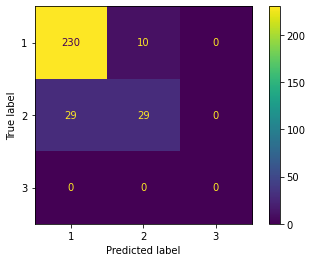

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(labels, predictions, labels=[1,2,3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3])
disp.plot()
plt.show()